# Part I - Original Land-Cover Composition & Reclassification

Augusto Pablo Salonio Carbó  
2025-11-11

## 1. Overview

Calculates the percentage of each original 16-class ESA CCI land-cover
map (200m) and reclassifies them into 8 functional classes.

### Key outputs:

-   Original Land Cover percentages (Table + Excel)

-   Top-3 classes bar plot by year

-   Reclassified 1999, 2009 and 2018 Rasters (GeoTiff)

## 2. Packages & Paths

In [ ]:
library(terra)
library(dplyr)
library(ggplot2)
library(openxlsx)

repo_root <- rprojroot::find_root(rprojroot::is_git_root)

raw_dir   <- file.path(repo_root, "data")
bound_dir <- file.path(repo_root, "data")
out_dir   <- file.path(repo_root, "output") 

dir.create(out_dir, showWarnings = FALSE, recursive = TRUE)

## 3. Load Original Rasters

In [ ]:
cover_1999 <- rast(file.path(raw_dir, "Land_cover_1999_200m.tif"))
cover_2009 <- rast(file.path(raw_dir, "Land_cover_2009_200m.tif"))
cover_2018 <- rast(file.path(raw_dir, "Land_cover_2018_200m.tif"))

# Convert to factor (required for classify())
cover_1999_f <- as.factor(cover_1999)
cover_2009_f <- as.factor(cover_2009)
cover_2018_f <- as.factor(cover_2018)

## 4. Original 16-Class Composition

In [ ]:
ORIG_CLASS_NAMES <- c(
  "Water", "Sand", "Medit. Sclerophyll", "Temperate Forest",
  "Eucalyptus", "Fruit Trees", "Glacier", "Riparian",
  "Shrub", "Pinus radiata", "Crops", "Grassland",
  "Bare soil", "Peatland", "Human structure", "Harvested plantation"
)

### 4.1 Helper: coverage per year

In [ ]:
compute_coverage <- function(rast, year) {
  freq(rast) %>%
    filter(!is.na(value)) %>%
    mutate(
      percentage = round(count / sum(count) * 100, 1),
      year       = year
    ) %>%
    arrange(desc(percentage))
}

freq_1999 <- compute_coverage(cover_1999, "1999")
freq_2009 <- compute_coverage(cover_2009, "2009")
freq_2018 <- compute_coverage(cover_2018, "2018")

### 4.2 Summary table

In [ ]:
coverage_summary <- bind_rows(freq_1999, freq_2009, freq_2018) %>%
  left_join(
    data.frame(value = 1:16, original_class = ORIG_CLASS_NAMES),
    by = "value"
  ) %>%
  select(year, original_class, value, count, percentage) %>%
  arrange(year, desc(percentage))

top_3_land_cover<- coverage_summary %>%
  group_by(year) %>%
  slice_max(percentage, n = 3) %>%
  ungroup() %>%
  dplyr::select(year, original_class, percentage) |> 
  print()

# A tibble: 9 × 3
  year  original_class   percentage
  <chr> <chr>                 <dbl>
1 1999  Temperate Forest       33.7
2 1999  Crops                  29.2
3 1999  Pinus radiata          14.5
4 2009  Temperate Forest       31.5
5 2009  Crops                  27.6
6 2009  Shrub                  14.3
7 2018  Temperate Forest       26.1
8 2018  Crops                  24.2
9 2018  Shrub                  21.8

### 4.3 Top-3 bar plot

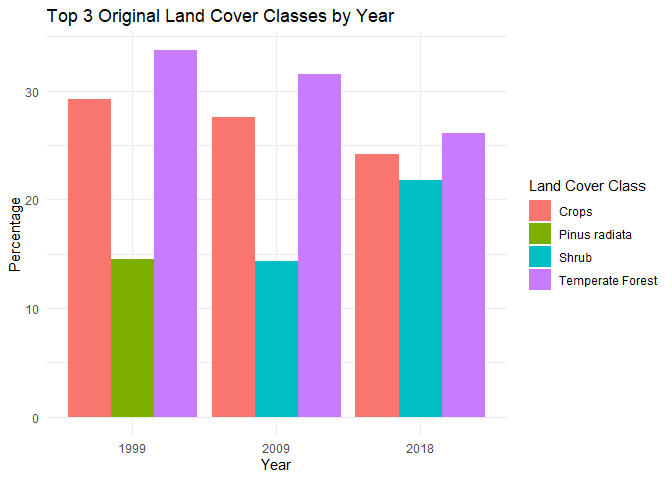

In [ ]:
ggplot(top_3_land_cover, aes(x = year, y = percentage, fill = original_class)) +
  geom_col(position = "dodge") +
  labs(
    title = "Top 3 Original Land Cover Classes by Year",
    x = "Year",
    y = "Percentage",
    fill = "Land Cover Class"
  ) +
  theme_minimal()

### Insight (km²‑scaled)

Temperate Forest lost 7.6% of its area (≈‑5400 km²) with the largest
drop (-5.4%) between 2009-2018. Crops shrank steadily (-5%). Shrub
entered the top-3 in 2018 (+7.5% ≈ +5300 km²) - likely natural
succession or abandonment.

Pinus radiata plantations dropped out of the top 3 after 1999 indicating
possible harvesting or conversion.

## 5. Reclassification to 8 Functional classes

In [ ]:
reclass_matrix <- matrix(c(
  # from → to
  1,1, 2,1, 7,1, 13,1,   # 1 Water_Bare = Water + Sand + Glacier + Bare soil
  3,2, 4,2, 8,2,         # 2 Native = Medit. Sclerophyll + Temperate Forest + Riparian
  5,3, 6,3, 10,3,        # 3 Plant = Eucalyptus + Fruit Trees + Pinus radiata
  9,4, 16,4,             # 4 Shrub = Shrub + Harvested plantation
  11,5,                  # 5 Crop = Crops
  12,6,                  # 6 Grass = Grassland
  14,7,                  # 7 Peat = Peatland
  15,8                   # 8 Urban = Human structure
), ncol = 2, byrow = TRUE)


reclass_cover_1999 <- classify(cover_1999_f, reclass_matrix)
reclass_cover_2009 <- classify(cover_2009_f, reclass_matrix)
reclass_cover_2018 <- classify(cover_2018_f, reclass_matrix)


new_levels <- data.frame(
  ID       = 1:8,
  Category = c("Water_Bare", "Native", "Plant", "Shrub",
               "Crop", "Grass", "Peat", "Urban")
)

levels(reclass_cover_1999) <- new_levels
levels(reclass_cover_2009) <- new_levels
levels(reclass_cover_2018) <- new_levels

## 6. Export

In [ ]:
xlsx_file <- file.path(out_dir, "original_landcover_percentages.xlsx")
write.xlsx(coverage_summary, xlsx_file, rowNames = FALSE)

writeRaster(
  reclass_cover_1999,
  file.path(out_dir, "reclass_cover_1999.tif"),
  overwrite = TRUE
)
writeRaster(
  reclass_cover_2009,
  file.path(out_dir, "reclass_cover_2009.tif"),
  overwrite = TRUE
)
writeRaster(
  reclass_cover_2018,
  file.path(out_dir, "reclass_cover_2018.tif"),
  overwrite = TRUE
)